# Deep Autoencoding Gaussian Mixture Model for Unsupervised Anomaly Detection

In [1]:
import numpy as np 
import pandas as pd
import torch
from data_loader import *
from main import *
from tqdm import tqdm

C:\Users\VIPLab\AppData\Local\conda\conda\envs\pytorch\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## KDD Cup 1999 Data (10% subset)
This is the data set used for The Third International Knowledge Discovery and Data Mining Tools Competition, which was held in conjunction with KDD-99 The Fifth International Conference on Knowledge Discovery and Data Mining. The competition task was to build a network intrusion detector, a predictive model capable of distinguishing between "bad" connections, called intrusions or attacks, and "good" normal connections. This database contains a standard set of data to be audited, which includes a wide variety of intrusions simulated in a military network environment. 

In [2]:
data = pd.read_csv("kddcup.data_10_percent_corrected", header=None,names=['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'type'])

### Pre-processing
Following the paper, since the "normal" only comprises of approximately 20% of the entries, the "normal" data were considered as anomalies instead.

In [3]:
data.loc[data["type"] != "normal.", 'type'] = 0
data.loc[data["type"] == "normal.", 'type'] = 1

Next, the categorical variables are converted to a one hot encoding representation. My implementation is a bit different from the original paper in this aspect. Since I am only using the 10% subset to generate the columns, I get 118 features instead of 120 as reported in the paper.

In [4]:
one_hot_protocol = pd.get_dummies(data["protocol_type"])
one_hot_service = pd.get_dummies(data["service"])
one_hot_flag = pd.get_dummies(data["flag"])

data = data.drop("protocol_type",axis=1)
data = data.drop("service",axis=1)
data = data.drop("flag",axis=1)
    
data = pd.concat([one_hot_protocol, one_hot_service,one_hot_flag, data],axis=1)
data.head()

,icmp,tcp,udp,IRC,X11,Z39_50,auth,bgp,courier,csnet_ns,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,type
0,0,1,0,0,0,0,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,1
1,0,1,0,0,0,0,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,1
2,0,1,0,0,0,0,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,1
3,0,1,0,0,0,0,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,1
4,0,1,0,0,0,0,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,1


In [5]:
proportions = data["type"].value_counts()
print(proportions)
print("Anomaly Percentage",proportions[1] / proportions.sum())

0    396743
1     97278
Name: type, dtype: int64
Anomaly Percentage 0.19691065764410826


Normalize all the numeric variables.

In [6]:
cols_to_norm = ["duration", "src_bytes", "dst_bytes", "wrong_fragment", "urgent", 
            "hot", "num_failed_logins", "num_compromised", "num_root", 
            "num_file_creations", "num_shells", "num_access_files", "count", "srv_count", 
            "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate", 
            "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate", 
            "dst_host_diff_srv_rate", "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", 
            "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate" ]

# data.loc[:, cols_to_norm] = (data[cols_to_norm] - data[cols_to_norm].mean()) / data[cols_to_norm].std()
min_cols = data.loc[data["type"]==0 , cols_to_norm].min()
max_cols = data.loc[data["type"]==0 , cols_to_norm].max()

data.loc[:, cols_to_norm] = (data[cols_to_norm] - min_cols) / (max_cols - min_cols)

I saved the preprocessed data into a numpy file format and load it using the pytorch data loader.

In [7]:
np.savez_compressed("kdd_cup",kdd=data.as_matrix())

I initially implemented this to be ran in the command line and use argparse to get the hyperparameters. To make it runnable in a jupyter notebook, I had to create a dummy class for the hyperparameters.

In [2]:
class hyperparams():
    def __init__(self, config):
        self.__dict__.update(**config)
defaults = {
    'lr' : 1e-4,
    'num_epochs' : 200,
    'batch_size' : 1024,
    'gmm_k' : 4,
    'lambda_energy' : 0.1,
    'lambda_cov_diag' : 0.005,
    'pretrained_model' : None,
    'mode' : 'train',
    'use_tensorboard' : False,
    'data_path' : 'kdd_cup.npz',

    'log_path' : './dagmm/logs',
    'model_save_path' : './dagmm/models',
    'sample_path' : './dagmm/samples',
    'test_sample_path' : './dagmm/test_samples',
    'result_path' : './dagmm/results',

    'log_step' : 194//4,
    'sample_step' : 194,
    'model_save_step' : 194,
}

Elapsed 0:28:22.371865/0:00:00.131633 -- 0:00:00.131633 , Epoch [200/200], Iter [192/194], lr 0.0001, total_loss: 0.1894, sample_energy: 0.5388, recon_error: 0.0788, cov_diag: 11.3455


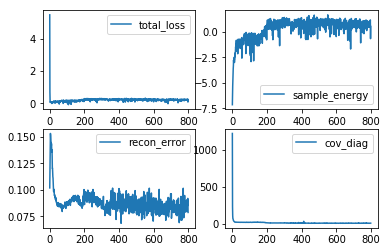

phi tensor([ 0.0042,  0.9909,  0.0032,  0.0017], device='cuda:0') mu tensor([[ 0.2632,  1.0881,  0.1980],
        [-1.6156,  0.8422, -0.4742],
        [-0.1509,  0.9353,  0.1885],
        [ 0.2075,  0.8453,  0.2090]], device='cuda:0') cov tensor([[[ 6.7847, -1.0272,  2.1146],
         [-1.0272,  2.6332, -0.5521],
         [ 2.1146, -0.5521,  0.7540]],

        [[ 6.0255, -0.7950,  2.0536],
         [-0.7950,  0.2630, -0.2839],
         [ 2.0536, -0.2839,  0.7041]],

        [[ 7.2182, -0.9259,  1.9753],
         [-0.9259,  1.7871, -0.4390],
         [ 1.9753, -0.4390,  0.7156]],

        [[ 7.2324, -1.0829,  2.2385],
         [-1.0829,  1.6545, -0.4776],
         [ 2.2385, -0.4776,  0.7902]]], device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████| 194/194 [00:08<00:00, 23.20it/s]


======================TEST MODE======================
N: 198371
phi :
 tensor([ 0.0007,  0.9984,  0.0006,  0.0003], device='cuda:0')
mu :
 tensor([[-0.2610,  2.6686, -0.1194],
        [-1.4987,  0.8442, -0.4426],
        [-1.0019,  1.8008, -0.0609],
        [-0.3958,  2.1473, -0.1113]], device='cuda:0')
cov :
 tensor([[[ 4.6235,  0.3735,  1.3941],
         [ 0.3735,  5.3684, -0.3503],
         [ 1.3941, -0.3503,  0.5130]],

        [[ 6.2791, -0.7967,  2.1476],
         [-0.7967,  0.3265, -0.2902],
         [ 2.1476, -0.2902,  0.7400]],

        [[ 5.2532,  0.5667,  1.2209],
         [ 0.5667,  3.7280, -0.3171],
         [ 1.2209, -0.3171,  0.5404]],

        [[ 5.4533,  0.1742,  1.6589],
         [ 0.1742,  4.7808, -0.3665],
         [ 1.6589, -0.3665,  0.6084]]], device='cuda:0')
Threshold : 4.2397990226745605
Accuracy : 0.9746, Precision : 0.9683, Recall : 0.9540, F-score : 0.9611


In [24]:
solver = main(hyperparams(defaults))
accuracy, precision, recall, f_score = solver.test()

### I copy pasted the testing code here in the notebook so we could play around the results.

### Incrementally compute for the GMM parameters across all training data for a better estimate

In [25]:
solver.data_loader.dataset.mode="train"
solver.dagmm.eval()
N = 0
mu_sum = 0
cov_sum = 0
gamma_sum = 0

for it, (input_data, labels) in enumerate(solver.data_loader):
    input_data = solver.to_var(input_data)
    enc, dec, z, gamma = solver.dagmm(input_data)
    phi, mu, cov = solver.dagmm.compute_gmm_params(z, gamma)
    
    batch_gamma_sum = torch.sum(gamma, dim=0)
    
    gamma_sum += batch_gamma_sum
    mu_sum += mu * batch_gamma_sum.unsqueeze(-1) # keep sums of the numerator only
    cov_sum += cov * batch_gamma_sum.unsqueeze(-1).unsqueeze(-1) # keep sums of the numerator only
    
    N += input_data.size(0)
    
train_phi = gamma_sum / N
train_mu = mu_sum / gamma_sum.unsqueeze(-1)
train_cov = cov_sum / gamma_sum.unsqueeze(-1).unsqueeze(-1)

print("N:",N)
print("phi :\n",train_phi)
print("mu :\n",train_mu)
print("cov :\n",train_cov)

N: 198371
phi :
 tensor([ 0.0007,  0.9984,  0.0006,  0.0003], device='cuda:0')
mu :
 tensor([[-0.2610,  2.6686, -0.1194],
        [-1.4987,  0.8442, -0.4426],
        [-1.0019,  1.8008, -0.0609],
        [-0.3958,  2.1473, -0.1113]], device='cuda:0')
cov :
 tensor([[[ 4.6220,  0.3708,  1.3943],
         [ 0.3708,  5.3609, -0.3502],
         [ 1.3943, -0.3502,  0.5129]],

        [[ 6.2786, -0.7967,  2.1474],
         [-0.7967,  0.3265, -0.2902],
         [ 2.1474, -0.2902,  0.7399]],

        [[ 5.2330,  0.5535,  1.2254],
         [ 0.5535,  3.7158, -0.3141],
         [ 1.2254, -0.3141,  0.5394]],

        [[ 5.4512,  0.1713,  1.6592],
         [ 0.1713,  4.7742, -0.3663],
         [ 1.6592, -0.3663,  0.6083]]], device='cuda:0')


In [26]:
train_energy = []
train_labels = []
train_z = []
for it, (input_data, labels) in enumerate(solver.data_loader):
    input_data = solver.to_var(input_data)
    enc, dec, z, gamma = solver.dagmm(input_data)
    sample_energy, cov_diag = solver.dagmm.compute_energy(z, phi=train_phi, mu=train_mu, cov=train_cov, size_average=False)
    
    train_energy.append(sample_energy.data.cpu().numpy())
    train_z.append(z.data.cpu().numpy())
    train_labels.append(labels.numpy())


train_energy = np.concatenate(train_energy,axis=0)
train_z = np.concatenate(train_z,axis=0)
train_labels = np.concatenate(train_labels,axis=0)

### Compute the energy of every sample in the test data

In [27]:
solver.data_loader.dataset.mode="test"
test_energy = []
test_labels = []
test_z = []
for it, (input_data, labels) in enumerate(solver.data_loader):
    input_data = solver.to_var(input_data)
    enc, dec, z, gamma = solver.dagmm(input_data)
    sample_energy, cov_diag = solver.dagmm.compute_energy(z, size_average=False)
    test_energy.append(sample_energy.data.cpu().numpy())
    test_z.append(z.data.cpu().numpy())
    test_labels.append(labels.numpy())


test_energy = np.concatenate(test_energy,axis=0)
test_z = np.concatenate(test_z,axis=0)
test_labels = np.concatenate(test_labels,axis=0)

In [28]:
combined_energy = np.concatenate([train_energy, test_energy], axis=0)
combined_z = np.concatenate([train_z, test_z], axis=0)
combined_labels = np.concatenate([train_labels, test_labels], axis=0)

### Compute for the threshold energy. Following the paper I just get the highest 20% and treat it as an anomaly. That corresponds to setting the threshold at the 80th percentile.

In [29]:
thresh = np.percentile(combined_energy, 100 - 20)
print("Threshold :", thresh)

Threshold : 4.774040222167969


In [34]:
pred = (test_energy>thresh).astype(int)
gt = test_labels.astype(int)

In [35]:
from sklearn.metrics import precision_recall_fscore_support as prf, accuracy_score

In [36]:
accuracy = accuracy_score(gt,pred)
precision, recall, f_score, support = prf(gt, pred, average='binary')

In [37]:
print("Accuracy : {:0.4f}, Precision : {:0.4f}, Recall : {:0.4f}, F-score : {:0.4f}".format(accuracy,precision, recall, f_score))

Accuracy : 0.9743, Precision : 0.9677, Recall : 0.9538, F-score : 0.9607


## Visualizing the z space
It's a little different from the paper's figure but I assume that's because of the small changes in my implementation.

<IPython.core.display.Javascript object>


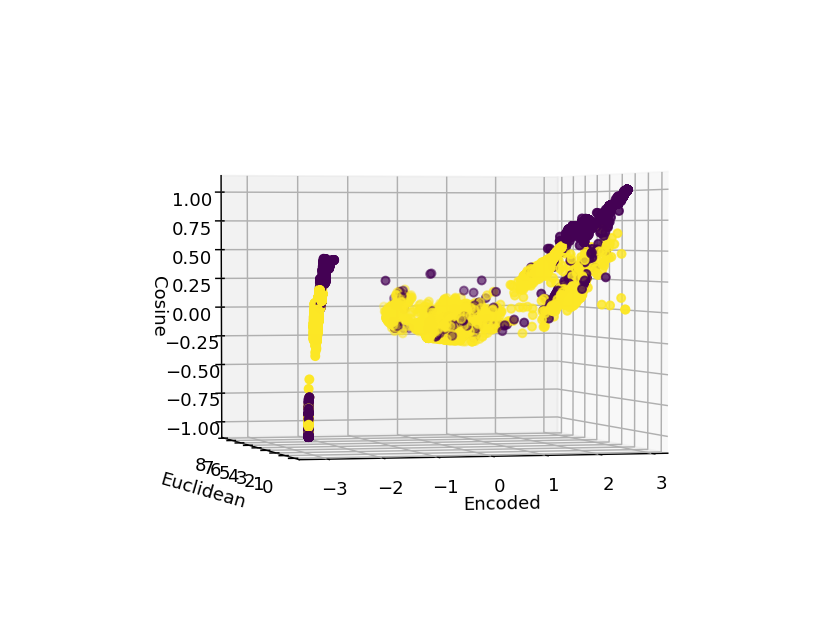

In [44]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(test_z[:,1],test_z[:,0], test_z[:,2], c=test_labels.astype(int))
ax.set_xlabel('Encoded')
ax.set_ylabel('Euclidean')
ax.set_zlabel('Cosine')
plt.show()